In [2]:
%load_ext autoreload
%autoreload 2
from optimize_psi import *
from cluster_g_logit_init_acceptpsi import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import rpy2.robjects as robjects
import numpy as np
import os as os
from rpy2.robjects import numpy2ri
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt



# Specify the path to your data files
data_path = "/Users/sarahurbut/tensornoulli_ehr_new/data"

# Activate automatic conversion between R and NumPy arrays
numpy2ri.activate()# Load data saved as .rds files
Y = np.array(robjects.r['readRDS'](os.path.join(data_path, 'Y.rds')))
E = np.array(robjects.r['readRDS'](os.path.join(data_path, 'event_for_aladynoulli.rds')))
G = np.array(robjects.r['readRDS'](os.path.join(data_path, 'prs.rds')))

E = E.astype(int)

# G should be float64
G = G.astype(float)
G.shape
G = G.T
print("G shape after transposition:", G.shape)

# Convert to PyTorch tensors
Y_tensor = torch.FloatTensor(Y)
E_tensor = torch.FloatTensor(E)
G_tensor = torch.FloatTensor(G)

# Get dimensions
N, D, T = Y_tensor.shape
P = G_tensor.shape[1]
T = int(E_tensor.max() + 1)  # 0-indexed time
K = 10  # number of topics

# Print shapes to verify
print("Tensor shapes:")
print(f"Y: {Y_tensor.shape}")  # [N, D]
print(f"E: {E_tensor.shape}")  # [N, D]
print(f"G: {G_tensor.shape}")  # [N, P]
print(f"Time range: 0 to {T-1}")
print(T)
print(K)


import rpy2.robjects as robjects
import pandas as pd
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the metadata from R
disease_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/disease_names.rds'))
prs_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/prs_names.rds'))
disease_names_list = disease_names[0].tolist()

G shape after transposition: (9661, 36)
Tensor shapes:
Y: torch.Size([9661, 348, 51])
E: torch.Size([9661, 348])
G: torch.Size([9661, 36])
Time range: 0 to 50
51
10


In [7]:
prevalence_t=compute_smoothed_prevalence(Y=Y,window_size=5)
K=20


In [8]:
        # Convert Y to tensor if it's not already
Y_tensor = torch.tensor(Y) if isinstance(Y, np.ndarray) else Y
  

In [9]:
# Define psi configurations to try
psi_configs = [
{'in_cluster': 1.0, 'out_cluster': -3.0, 'noise_in': 0.1, 'noise_out': 0.01},
{'in_cluster': 2.0, 'out_cluster': -4.0, 'noise_in': 0.1, 'noise_out': 0.01},
{'in_cluster': 1.5, 'out_cluster': -3.5, 'noise_in': 0.05, 'noise_out': 0.01},
{'in_cluster': 2.5, 'out_cluster': -3.0, 'noise_in': 0.1, 'noise_out': 0.01},
]


In [10]:
def compute_metrics(model, val_data):
        """Compute both prediction accuracy and cluster separation metrics"""
        with torch.no_grad():
            pi, theta, phi = model()
            
            # Prediction metrics
            val_r2 = compute_r2(model)
            
            # Cluster separation metrics
            cluster_sep = compute_cluster_separation(model.psi)
            
            return {
                'r2': val_r2,
                'cluster_separation': cluster_sep,
                'combined_score': val_r2 + 0.2 * cluster_sep  # Weighted combination
            }
    
def compute_r2(model):
        """Compute calibrated R² score"""
        # 1. Get predictions and actual values
        predicted = model.forward()
        pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
        pi_pred = pi_pred.cpu().detach().numpy()
        Y = model.Y.cpu().detach().numpy()

        # 2. Calculate marginal risks directly
        # Assuming dimensions are: [N, D, T] for both Y and pi_pred
        observed_risk = Y.mean(axis=0).flatten()  # average across individuals
        predicted_risk = pi_pred.mean(axis=0).flatten()
 
# 3. Apply calibration
        scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
        calibrated_risk = predicted_risk * scale_factor

        ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
        ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
        cr2 = 1 - (ss_res / ss_tot)
        return cr2
    
def compute_cluster_separation(psi):
        """Measure how well-separated the clusters are"""
        psi_np = psi.detach().cpu().numpy()
        return np.mean(np.max(psi_np, axis=0) - np.min(psi_np, axis=0))
 

In [24]:
# Define new psi configurations focused on optimizing R²
psi_configs = [
    # More moderate values to start
    {'in_cluster': 0.5, 'out_cluster': -0.5, 'noise_in': 0.1, 'noise_out': 0.01},
    {'in_cluster': 1.0, 'out_cluster': -1.0, 'noise_in': 0.1, 'noise_out': 0.01},
    {'in_cluster': 1.5, 'out_cluster': -1.5, 'noise_in': 0.1, 'noise_out': 0.01},
    # Try different noise levels
    {'in_cluster': 1.0, 'out_cluster': -1.0, 'noise_in': 0.05, 'noise_out': 0.01},
    {'in_cluster': 1.0, 'out_cluster': -1.0, 'noise_in': 0.2, 'noise_out': 0.01},
]

results = []
for i, config in enumerate(psi_configs):
    print(f"\nTrying configuration {i+1}/{len(psi_configs)}:")
    print(f"Parameters: {config}")
        
    model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
        N, D, T, K, P, G_tensor, Y=Y, 
        prevalence_t=prevalence_t,
        disease_names=disease_names_list
    )
    model.initialize_params(psi_config=config)
    
    # Increase number of epochs for better convergence
    metrics = model.fit_efficient(
        E_tensor,
        learning_rate=1e-4,
        param_change_threshold=1e-4,  # More stringent threshold
        consecutive_threshold=5,
        num_epochs=10  # More epochs
    )
    
    metrics = compute_metrics(model, Y_tensor)
    results.append({
        'config': config,
        'metrics': metrics
    })
    print(f"R²: {metrics['r2']:.4f}")

# Sort results by R² score
sorted_results = sorted(results, key=lambda x: x['metrics']['r2'], reverse=True)
print("\nBest configurations by R²:")
for i, result in enumerate(sorted_results[:3]):
    print(f"\n{i+1}. R² = {result['metrics']['r2']:.4f}")
    print(f"Configuration: {result['config']}")


Trying configuration 1/5:
Parameters: {'in_cluster': 0.5, 'out_cluster': -0.5, 'noise_in': 0.1, 'noise_out': 0.01}
Lambda kernel condition number: 45200668.00
Phi kernel condition number: 89734320.00


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 27 diseases
Cluster 1: 32 diseases
Cluster 2: 12 diseases
Cluster 3: 9 diseases
Cluster 4: 19 diseases
Cluster 5: 74 diseases
Cluster 6: 31 diseases
Cluster 7: 12 diseases
Cluster 8: 10 diseases
Cluster 9: 8 diseases
Cluster 10: 5 diseases
Cluster 11: 10 diseases
Cluster 12: 6 diseases
Cluster 13: 12 diseases
Cluster 14: 14 diseases
Cluster 15: 9 diseases
Cluster 16: 23 diseases
Cluster 17: 5 diseases
Cluster 18: 18 diseases
Cluster 19: 12 diseases
Initialization complete!

Using psi configuration
Initialization complete!
Starting efficient training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Epoch 0
Loss: 1104.3820
Max parameter change: 0.00e+00
Max gradients: {'lambda': 0.5445839762687683, 'phi': 13.434080123901367, 'psi': 0.02079296112060547, 'gamma': 0.05656219273805618}
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Estimated total training time: 16.7 minutes
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
m

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 27 diseases
Cluster 1: 32 diseases
Cluster 2: 12 diseases
Cluster 3: 9 diseases
Cluster 4: 19 diseases
Cluster 5: 74 diseases
Cluster 6: 31 diseases
Cluster 7: 12 diseases
Cluster 8: 10 diseases
Cluster 9: 8 diseases
Cluster 10: 5 diseases
Cluster 11: 10 diseases
Cluster 12: 6 diseases
Cluster 13: 12 diseases
Cluster 14: 14 diseases
Cluster 15: 9 diseases
Cluster 16: 23 diseases
Cluster 17: 5 diseases
Cluster 18: 18 diseases
Cluster 19: 12 diseases
Initialization complete!

Using psi configuration
Initialization complete!
Starting efficient training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Epoch 0
Loss: 1102.1234
Max parameter change: 0.00e+00
Max gradients: {'lambda': 0.6031022667884827, 'phi': 14.702821731567383, 'psi': 0.016869544982910156, 'gamma': 0.05310511589050293}
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Estimated total training time: 16.9 minutes
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 27 diseases
Cluster 1: 32 diseases
Cluster 2: 12 diseases
Cluster 3: 9 diseases
Cluster 4: 19 diseases
Cluster 5: 74 diseases
Cluster 6: 31 diseases
Cluster 7: 12 diseases
Cluster 8: 10 diseases
Cluster 9: 8 diseases
Cluster 10: 5 diseases
Cluster 11: 10 diseases
Cluster 12: 6 diseases
Cluster 13: 12 diseases
Cluster 14: 14 diseases
Cluster 15: 9 diseases
Cluster 16: 23 diseases
Cluster 17: 5 diseases
Cluster 18: 18 diseases
Cluster 19: 12 diseases
Initialization complete!

Using psi configuration
Initialization complete!
Starting efficient training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Epoch 0
Loss: 1107.4857
Max parameter change: 0.00e+00
Max gradients: {'lambda': 0.545708954334259, 'phi': 13.712434768676758, 'psi': 0.017527103424072266, 'gamma': 0.05919883772730827}
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Estimated total training time: 16.9 minutes
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
m

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 27 diseases
Cluster 1: 32 diseases
Cluster 2: 12 diseases
Cluster 3: 9 diseases
Cluster 4: 19 diseases
Cluster 5: 74 diseases
Cluster 6: 31 diseases
Cluster 7: 12 diseases
Cluster 8: 10 diseases
Cluster 9: 8 diseases
Cluster 10: 5 diseases
Cluster 11: 10 diseases
Cluster 12: 6 diseases
Cluster 13: 12 diseases
Cluster 14: 14 diseases
Cluster 15: 9 diseases
Cluster 16: 23 diseases
Cluster 17: 5 diseases
Cluster 18: 18 diseases
Cluster 19: 12 diseases
Initialization complete!

Using psi configuration
Initialization complete!
Starting efficient training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Epoch 0
Loss: 1106.4600
Max parameter change: 0.00e+00
Max gradients: {'lambda': 0.552797794342041, 'phi': 13.66673755645752, 'psi': 0.018416404724121094, 'gamma': 0.05651224032044411}
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Estimated total training time: 16.4 minutes
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
ma

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 27 diseases
Cluster 1: 32 diseases
Cluster 2: 12 diseases
Cluster 3: 9 diseases
Cluster 4: 19 diseases
Cluster 5: 74 diseases
Cluster 6: 31 diseases
Cluster 7: 12 diseases
Cluster 8: 10 diseases
Cluster 9: 8 diseases
Cluster 10: 5 diseases
Cluster 11: 10 diseases
Cluster 12: 6 diseases
Cluster 13: 12 diseases
Cluster 14: 14 diseases
Cluster 15: 9 diseases
Cluster 16: 23 diseases
Cluster 17: 5 diseases
Cluster 18: 18 diseases
Cluster 19: 12 diseases
Initialization complete!

Using psi configuration
Initialization complete!
Starting efficient training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Epoch 0
Loss: 1101.2344
Max parameter change: 0.00e+00
Max gradients: {'lambda': 0.5437234044075012, 'phi': 12.62307357788086, 'psi': 0.01620197296142578, 'gamma': 0.06573784351348877}
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Estimated total training time: 13.9 minutes
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
ma

In [25]:
sorted_results

[{'config': {'in_cluster': 0.5,
   'out_cluster': -0.5,
   'noise_in': 0.1,
   'noise_out': 0.01},
  'metrics': {'r2': 0.8095290511846542,
   'cluster_separation': 1.0125045,
   'combined_score': 1.01202994287014}},
 {'config': {'in_cluster': 1.0,
   'out_cluster': -1.0,
   'noise_in': 0.05,
   'noise_out': 0.01},
  'metrics': {'r2': 0.7391408681869507,
   'cluster_separation': 2.0194259,
   'combined_score': 1.1430260419845581}},
 {'config': {'in_cluster': 1.0,
   'out_cluster': -1.0,
   'noise_in': 0.1,
   'noise_out': 0.01},
  'metrics': {'r2': 0.5407633781433105,
   'cluster_separation': 2.0260203,
   'combined_score': 0.945967435836792}},
 {'config': {'in_cluster': 1.0,
   'out_cluster': -1.0,
   'noise_in': 0.2,
   'noise_out': 0.01},
  'metrics': {'r2': 0.5048646628856659,
   'cluster_separation': 2.015817,
   'combined_score': 0.9080280482769012}},
 {'config': {'in_cluster': 1.5,
   'out_cluster': -1.5,
   'noise_in': 0.1,
   'noise_out': 0.01},
  'metrics': {'r2': 0.3296741247

In [12]:
results = []
for i, config in enumerate(psi_configs):
    print(f"\nTrying configuration {i+1}/{len(psi_configs)}:")
    print(f"Parameters: {config}")
   
        
    model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(N,D,T,K,P,G_tensor,Y=Y, prevalence_t=prevalence_t,disease_names=disease_names_list)
    model.initialize_params(psi_config=config)
    metrics = model.fit_efficient(
        E_tensor,
        learning_rate=1e-4,
        param_change_threshold=1e-3,  # Adjust based on your needs
        consecutive_threshold=3,num_epochs=5  # Stop after 3 consecutive small changes
    )
    metrics=compute_metrics(model,Y_tensor)
    results.append({
        'config': config,
        'metrics': metrics
    })

    print(f"Results for config {i+1}:")
    print(f"R²: {metrics['r2']:.4f}")
    print(f"Cluster separation: {metrics['cluster_separation']:.4f}")
    print(f"Combined score: {metrics['combined_score']:.4f}")







Trying configuration 1/4:
Parameters: {'in_cluster': 1.0, 'out_cluster': -3.0, 'noise_in': 0.1, 'noise_out': 0.01}
Lambda kernel condition number: 45200668.00
Phi kernel condition number: 89734320.00


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 27 diseases
Cluster 1: 32 diseases
Cluster 2: 12 diseases
Cluster 3: 9 diseases
Cluster 4: 19 diseases
Cluster 5: 74 diseases
Cluster 6: 31 diseases
Cluster 7: 12 diseases
Cluster 8: 10 diseases
Cluster 9: 8 diseases
Cluster 10: 5 diseases
Cluster 11: 10 diseases
Cluster 12: 6 diseases
Cluster 13: 12 diseases
Cluster 14: 14 diseases
Cluster 15: 9 diseases
Cluster 16: 23 diseases
Cluster 17: 5 diseases
Cluster 18: 18 diseases
Cluster 19: 12 diseases
Initialization complete!

Using psi configuration
Initialization complete!
Starting efficient training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Epoch 0
Loss: 1113.2926
Max parameter change: 0.00e+00
Max gradients: {'lambda': 0.544991135597229, 'phi': 14.414775848388672, 'psi': 0.018660306930541992, 'gamma': 0.06372722238302231}
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Estimated total training time: 8.4 minutes
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
Results for config 1:
R²: 0.1456
Cluster separation: 4.0269
Combined score: 0.9510

Trying configuration 2/4:
Parameters: {'in_cluster': 2.0, 'out_cluster': -4.0, 'noise_in': 0.1, 'noise_out': 0.01}
Lambda kernel condition number: 45200668.00
Phi kernel condi

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 27 diseases
Cluster 1: 32 diseases
Cluster 2: 12 diseases
Cluster 3: 9 diseases
Cluster 4: 19 diseases
Cluster 5: 74 diseases
Cluster 6: 31 diseases
Cluster 7: 12 diseases
Cluster 8: 10 diseases
Cluster 9: 8 diseases
Cluster 10: 5 diseases
Cluster 11: 10 diseases
Cluster 12: 6 diseases
Cluster 13: 12 diseases
Cluster 14: 14 diseases
Cluster 15: 9 diseases
Cluster 16: 23 diseases
Cluster 17: 5 diseases
Cluster 18: 18 diseases
Cluster 19: 12 diseases
Initialization complete!

Using psi configuration
Initialization complete!
Starting efficient training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Epoch 0
Loss: 1112.0760
Max parameter change: 0.00e+00
Max gradients: {'lambda': 0.5892748236656189, 'phi': 13.979254722595215, 'psi': 0.018330097198486328, 'gamma': 0.0721120685338974}
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Estimated total training time: 8.0 minutes
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
Results for config 2:
R²: -1.3260
Cluster separation: 6.0117
Combined score: -0.1237

Trying configuration 3/4:
Parameters: {'in_cluster': 1.5, 'out_cluster': -3.5, 'noise_in': 0.05, 'noise_out': 0.01}
Lambda kernel condition number: 45200668.00
Phi kernel co

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 27 diseases
Cluster 1: 32 diseases
Cluster 2: 12 diseases
Cluster 3: 9 diseases
Cluster 4: 19 diseases
Cluster 5: 74 diseases
Cluster 6: 31 diseases
Cluster 7: 12 diseases
Cluster 8: 10 diseases
Cluster 9: 8 diseases
Cluster 10: 5 diseases
Cluster 11: 10 diseases
Cluster 12: 6 diseases
Cluster 13: 12 diseases
Cluster 14: 14 diseases
Cluster 15: 9 diseases
Cluster 16: 23 diseases
Cluster 17: 5 diseases
Cluster 18: 18 diseases
Cluster 19: 12 diseases
Initialization complete!

Using psi configuration
Initialization complete!
Starting efficient training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Epoch 0
Loss: 1113.0100
Max parameter change: 0.00e+00
Max gradients: {'lambda': 0.5409991145133972, 'phi': 13.249998092651367, 'psi': 0.019799232482910156, 'gamma': 0.06156560033559799}
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Estimated total training time: 8.0 minutes
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
Results for config 3:
R²: -2.7820
Cluster separation: 5.0184
Combined score: -1.7784

Trying configuration 4/4:
Parameters: {'in_cluster': 2.5, 'out_cluster': -3.0, 'noise_in': 0.1, 'noise_out': 0.01}
Lambda kernel condition number: 45200668.00
Phi kernel co

/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 27 diseases
Cluster 1: 32 diseases
Cluster 2: 12 diseases
Cluster 3: 9 diseases
Cluster 4: 19 diseases
Cluster 5: 74 diseases
Cluster 6: 31 diseases
Cluster 7: 12 diseases
Cluster 8: 10 diseases
Cluster 9: 8 diseases
Cluster 10: 5 diseases
Cluster 11: 10 diseases
Cluster 12: 6 diseases
Cluster 13: 12 diseases
Cluster 14: 14 diseases
Cluster 15: 9 diseases
Cluster 16: 23 diseases
Cluster 17: 5 diseases
Cluster 18: 18 diseases
Cluster 19: 12 diseases
Initialization complete!

Using psi configuration
Initialization complete!
Starting efficient training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Epoch 0
Loss: 1108.8903
Max parameter change: 0.00e+00
Max gradients: {'lambda': 0.5873138904571533, 'phi': 13.408405303955078, 'psi': 0.02088022232055664, 'gamma': 0.05080139636993408}
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Estimated total training time: 27.7 minutes
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])
Results for config 4:
R²: 0.1054
Cluster separation: 5.5153
Combined score: 1.2084


In [13]:
results

[{'config': {'in_cluster': 1.0,
   'out_cluster': -3.0,
   'noise_in': 0.1,
   'noise_out': 0.01},
  'metrics': {'r2': 0.14559143781661987,
   'cluster_separation': 4.026948,
   'combined_score': 0.9509810328483582}},
 {'config': {'in_cluster': 2.0,
   'out_cluster': -4.0,
   'noise_in': 0.1,
   'noise_out': 0.01},
  'metrics': {'r2': -1.3260116577148438,
   'cluster_separation': 6.011744,
   'combined_score': -0.12366285324096671}},
 {'config': {'in_cluster': 1.5,
   'out_cluster': -3.5,
   'noise_in': 0.05,
   'noise_out': 0.01},
  'metrics': {'r2': -2.782043695449829,
   'cluster_separation': 5.018379,
   'combined_score': -1.7783678531646727}},
 {'config': {'in_cluster': 2.5,
   'out_cluster': -3.0,
   'noise_in': 0.1,
   'noise_out': 0.01},
  'metrics': {'r2': 0.10536205768585205,
   'cluster_separation': 5.5153484,
   'combined_score': 1.2084317445755006}}]

In [25]:
results = []
for config in psi_configs:
    print(f"\nTrying config: {config}")
    
    # Initialize model with this config
    model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
        N=len(train_idx), D=self.D, T=self.T, K=self.K, P=self.P,
        G=G_tensor[train_idx], Y=train_Y, prevalence_t=self.prevalence_t,
        disease_names=self.disease_names
    )
    model.initialize_params(psi_config=config)
    
    # Quick training with event times instead of Y
    metrics = self.quick_train(model, train_events, val_events, num_epochs=quick_epochs)
    
    results.append({
        'config': config,
        'metrics': metrics
    })
    print(f"R²: {metrics['r2']:.3f}")
    print(f"Cluster separation: {metrics['cluster_separation']:.3f}")
    print(f"Combined score: {metrics['combined_score']:.3f}")
       
      

{'r2': 0.2668132781982422,
 'cluster_separation': 6.016088,
 'combined_score': 1.4700308799743653}

In [27]:
psi_configs[1]

{'in_cluster': 1.0, 'out_cluster': -1.0, 'noise_in': 0.1, 'noise_out': 0.01}

In [124]:
psi_configs[1]

{'in_cluster': 1.0, 'out_cluster': -1.0, 'noise_in': 0.1, 'noise_out': 0.01}

In [28]:
# choosing the best

model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(N,D,T,K,P,G_tensor,Y=Y, prevalence_t=prevalence_t,disease_names=disease_names_list)
model.initialize_params(psi_config=psi_configs[1])


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)


Lambda kernel condition number: 45200668.00
Phi kernel condition number: 89734320.00

Cluster Sizes:
Cluster 0: 27 diseases
Cluster 1: 32 diseases
Cluster 2: 12 diseases
Cluster 3: 9 diseases
Cluster 4: 19 diseases
Cluster 5: 74 diseases
Cluster 6: 31 diseases
Cluster 7: 12 diseases
Cluster 8: 10 diseases
Cluster 9: 8 diseases
Cluster 10: 5 diseases
Cluster 11: 10 diseases
Cluster 12: 6 diseases
Cluster 13: 12 diseases
Cluster 14: 14 diseases
Cluster 15: 9 diseases
Cluster 16: 23 diseases
Cluster 17: 5 diseases
Cluster 18: 18 diseases
Cluster 19: 12 diseases
Initialization complete!

Using psi configuration
Initialization complete!


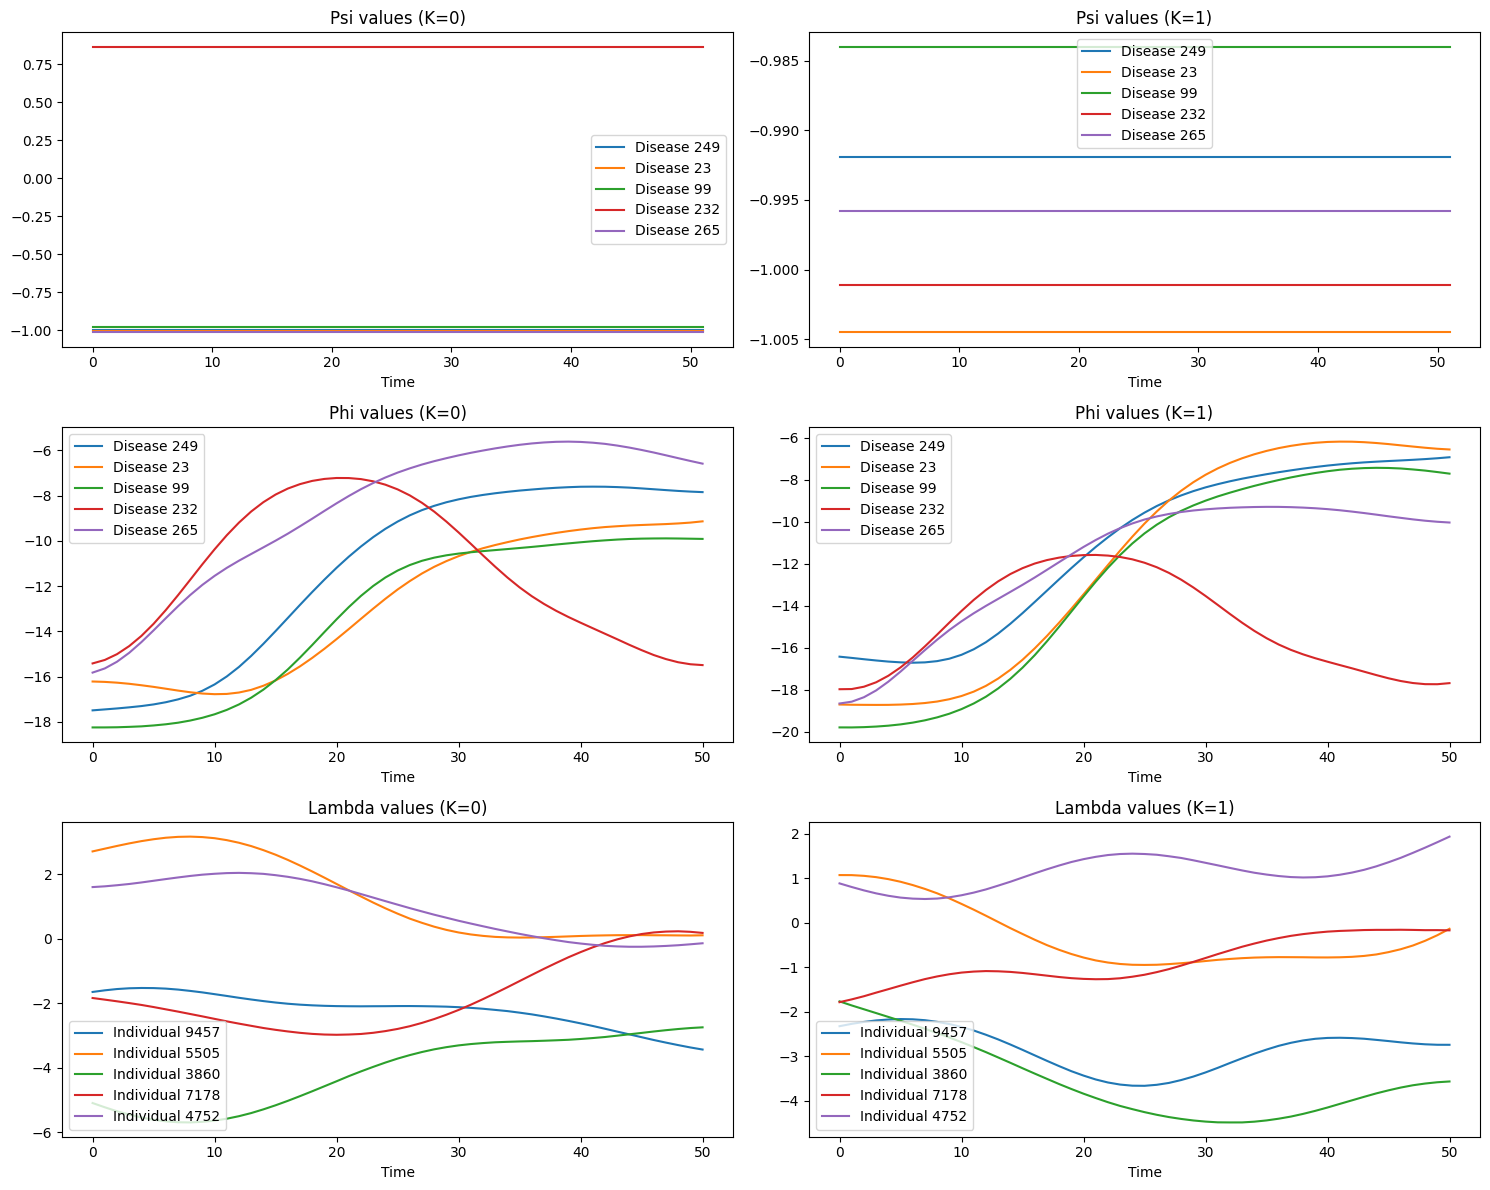


Cluster membership for sampled diseases:
Disease 249: Cluster 8
Disease 23: Cluster 19
Disease 99: Cluster 16
Disease 232: Cluster 0
Disease 265: Cluster 2


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:617: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


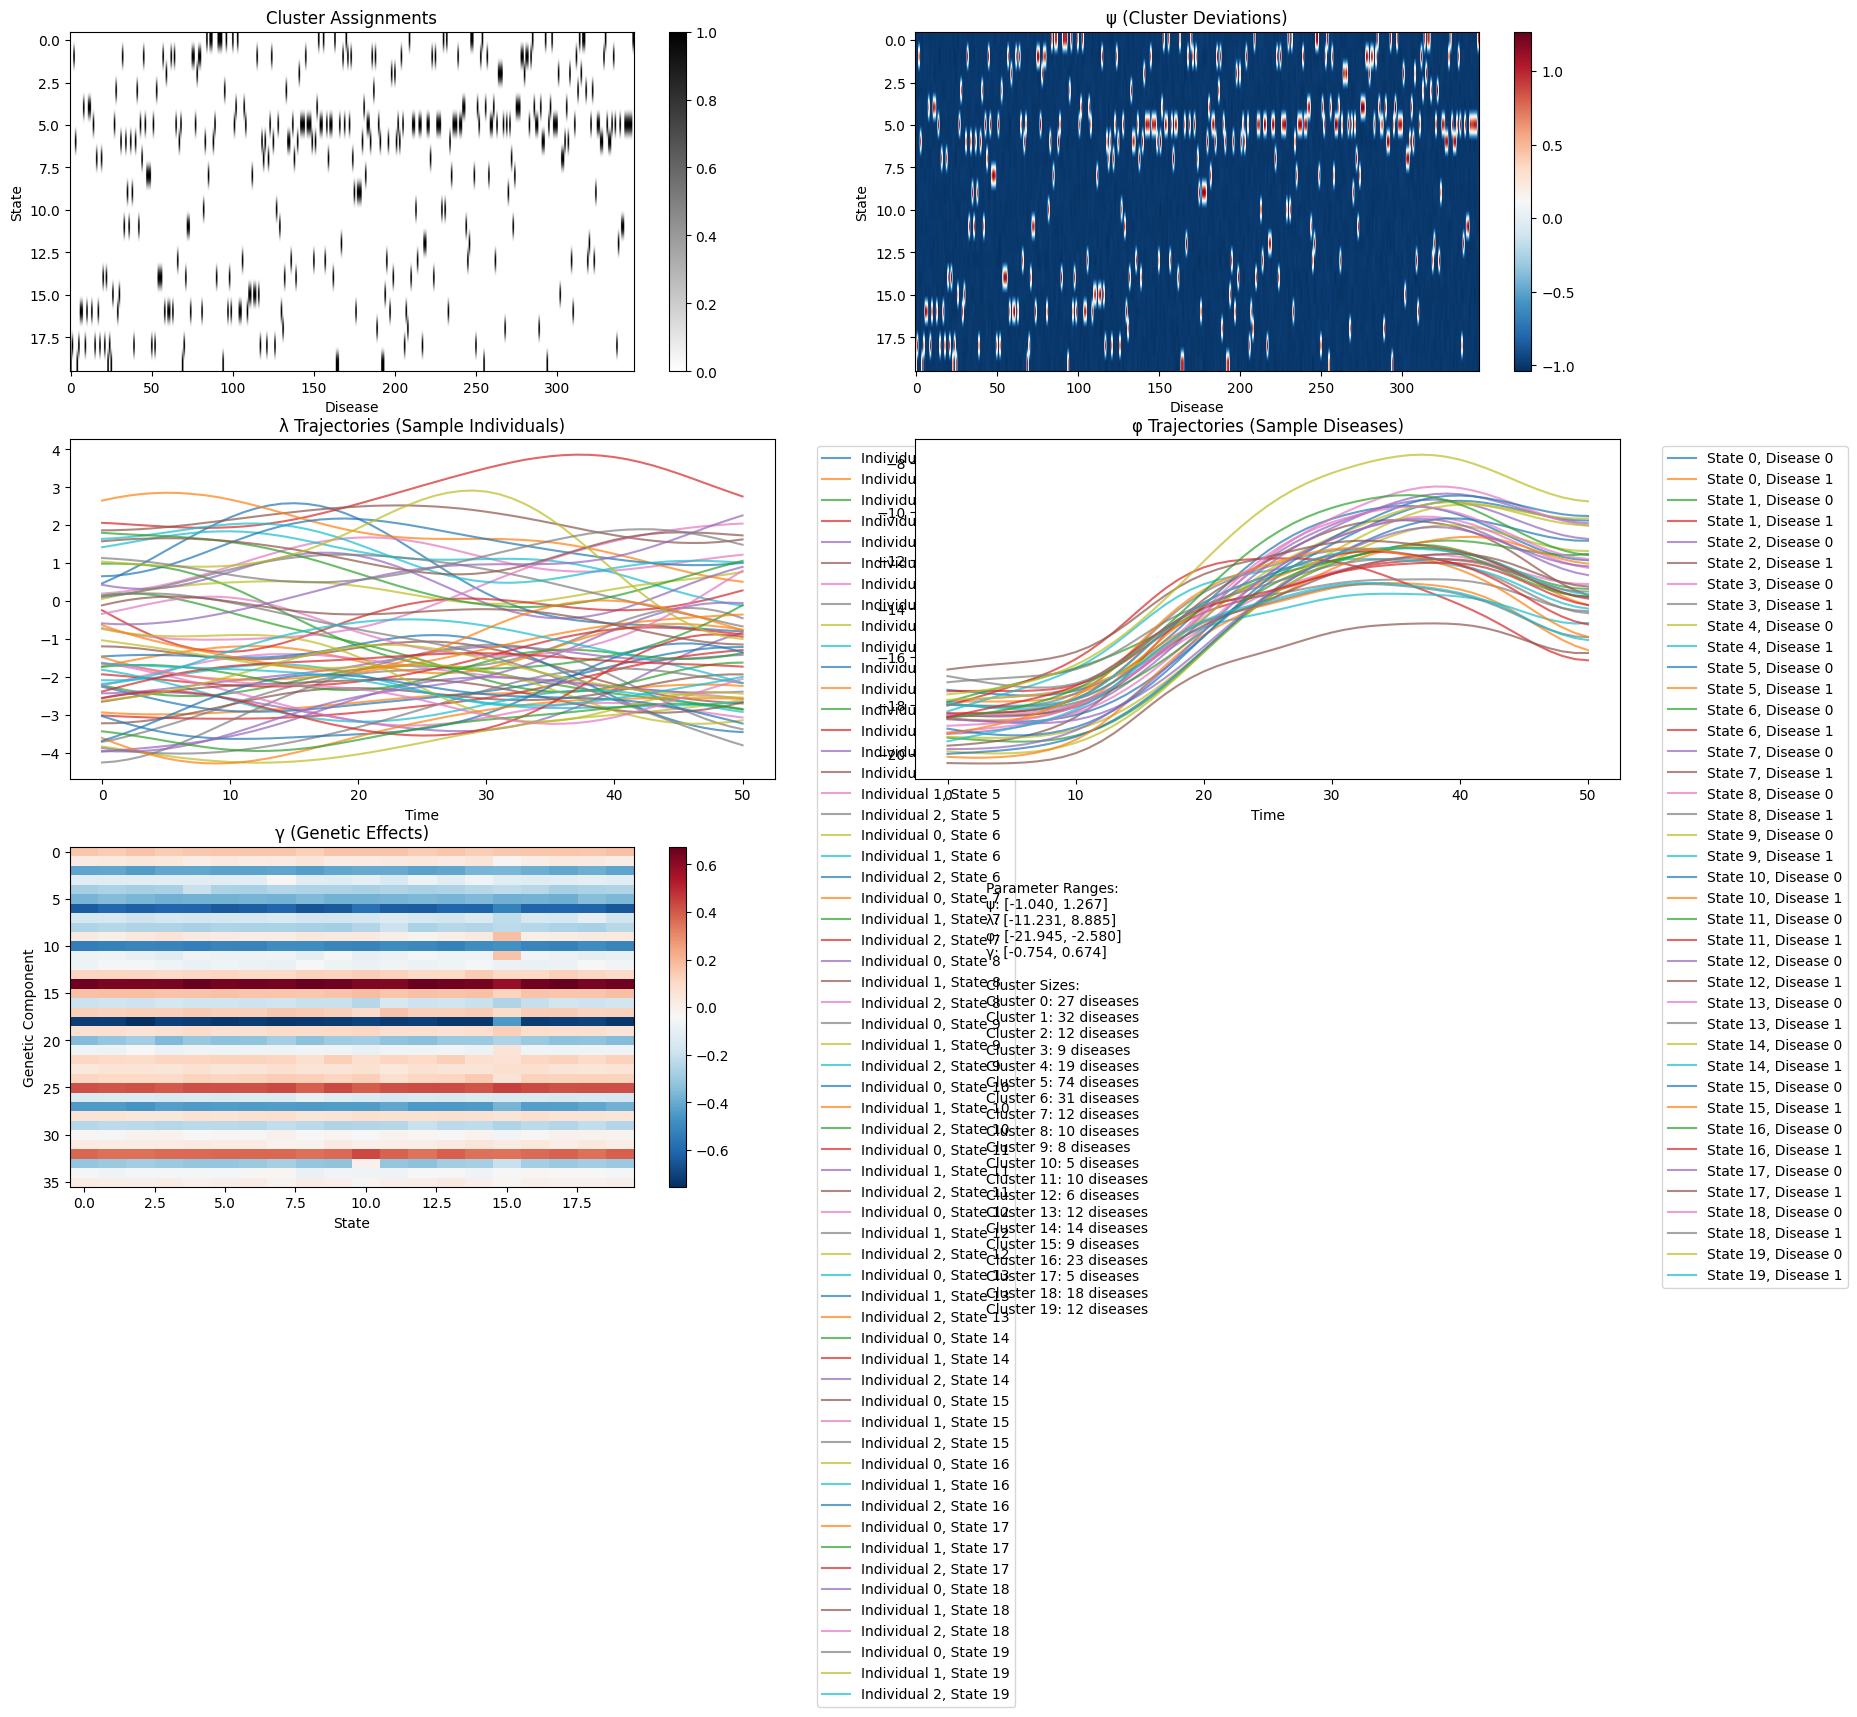

Parameter containing:
tensor([[-1.0000, -1.0051, -1.0137,  ..., -0.9927, -1.0056,  0.9356],
        [-0.9861, -1.0159,  1.0917,  ..., -0.9900, -0.9999, -1.0002],
        [-1.0044, -0.9996, -0.9974,  ..., -0.9833, -1.0062, -1.0040],
        ...,
        [-0.9901, -0.9986, -1.0161,  ..., -1.0033, -1.0053, -0.9975],
        [-1.0022,  1.0387, -1.0041,  ..., -1.0134, -1.0179, -0.9930],
        [ 1.0388, -1.0068, -1.0160,  ..., -0.9974, -1.0047, -1.0200]],
       requires_grad=True)

In [29]:
model.plot_initial_params()
model.visualize_initialization()
model.psi


In [30]:
history = model.fit(E_tensor, num_epochs=1000, learning_rate=1e-4, lambda_reg=1e-2)
        

Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Epoch 0
Loss: 1104.5300
Psi gradient stats:
Mean: -6.5646e-05
Std:  4.7189e-03
Max:  1.5497e-02
Min:  -1.6452e-02
Average psi change: 1.0002e-04
Epoch 0, Loss: 1104.5300, Gradients - Lambda: 5.452e-01, Phi: 1.473e+01, Gamma: 6.268e-02, Psi: 1.645e-02
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Epoch 1
Loss: 839.6895
Psi gradient stats:
Mean: -6.5060e-05
Std:  4.7064e-03
Max:  1.5365e-02
Min:  -1.6430e-02
Average psi change: 9.9328e-05
Epoch 1, Loss: 839.6895, Gradients - Lambda: 4.854e-01, Phi: 1.335e+01, Gamma: 6.120e-02, Psi: 1.643e-02

Estimated total training time: 1367.6 minutes
mask_before_event shape: torch.Size([9661, 348, 51])
mask_at_event shape: torch.Size([9661, 348, 51])

Epoch 2
Loss: 650.7554
Psi gradient stats:
Mean: -6.4895e-05
Std:  4.6943e-03
Max:  1.5272e-02
Min:  -1.6271e-02
Average psi change: 9.8993e-05


In [117]:
import torch

# Save complete state for R
# Save components as .rds files
save_path = '/Users/sarahurbut/Dropbox (Personal)/aladynoulli/model_complete_for_R_123_1_1_logitinit_nobg.pt'

torch.save({
    'model_state_dict': model.state_dict(),
    'clusters': model.clusters,
    'psi': model.psi,
    'Y': Y,
    'prevalence_t':prevalence_t,
    'G': G,
    'E': E,
    'disease_names': disease_names,
    'hyperparameters': {
        'N': N,
        'D': D,
        'T': T,
        'P': P,
        'K': K
    }
}, save_path)

import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
numpy2ri.activate()

# Extract key components from model
with torch.no_grad():
    pi_pred, theta, phi = model.forward()
    
# Convert tensors to numpy arrays - check type first
pi_pred = pi_pred.cpu().detach().numpy()
theta = theta.cpu().detach().numpy()
phi = model.phi.cpu().detach().numpy()
psi = model.psi.cpu().detach().numpy()
lambda_vals = model.lambda_.cpu().detach().numpy()

# These are already numpy arrays
clusters = model.clusters  # Already numpy


save_path = '/Users/sarahurbut/Dropbox (Personal)/aladynoulli/Rdata/11/'
# Main parameters
robjects.r.saveRDS(phi, f"{save_path}phi.rds")
robjects.r.saveRDS(psi, f"{save_path}psi.rds")
robjects.r.saveRDS(lambda_vals, f"{save_path}lambda.rds")
robjects.r.saveRDS(theta, f"{save_path}theta.rds")
robjects.r.saveRDS(pi_pred, f"{save_path}pi_pred.rds")
robjects.r.saveRDS(clusters, f"{save_path}clusters.rds")


<rpy2.rinterface_lib.sexp.NULLType object at 0x16fdb9700> [RTYPES.NILSXP]

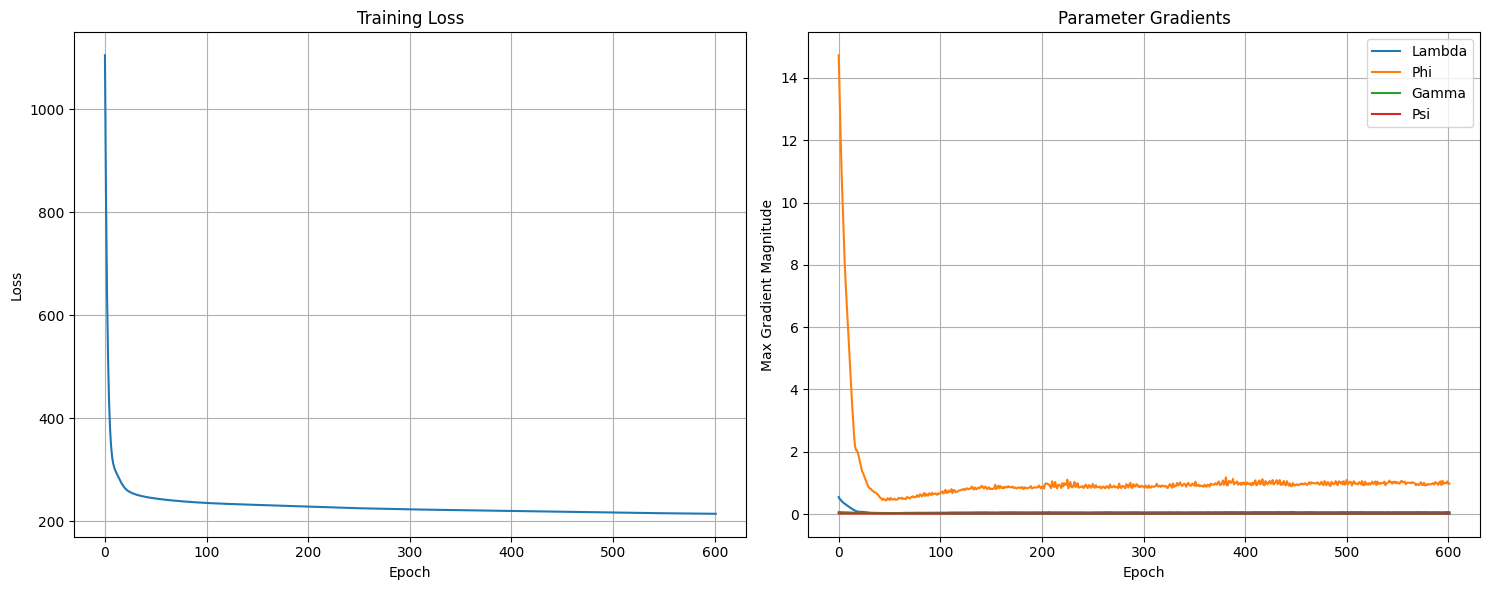

In [31]:
import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss
ax1.plot(history['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot gradients
ax2.plot(history['max_grad_lambda'], label='Lambda')
ax2.plot(history['max_grad_phi'], label='Phi')
ax2.plot(history['max_grad_gamma'], label='Gamma')
ax2.plot(history['max_grad_psi'], label='Psi')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Max Gradient Magnitude')
ax2.set_title('Parameter Gradients')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [32]:
def plot_signature_top_diseases_centered(model, disease_names, n_top=10):
    """
    Show top diseases for each signature, centered relative to prevalence
    """
    # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # For each signature, get top diseases
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        print(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):")
        for idx in top_indices:
            avg_effect = scores[idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            # Convert to odds ratio for interpretability
            odds_ratio = np.exp(avg_effect)
            print(f"{disease_names[idx]}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}")

# Run visualization
plot_signature_top_diseases_centered(model, disease_names_list)


Top 10 diseases in Signature 0 (relative to baseline):
Mucous polyp of cervix: effect=2.470 (OR=11.83), std=0.667
Malignant neoplasm of uterus: effect=2.039 (OR=7.68), std=0.307
Prolapse of vaginal walls: effect=1.975 (OR=7.20), std=0.678
Irregular menstrual bleeding: effect=1.967 (OR=7.15), std=0.634
Polyp of corpus uteri: effect=1.955 (OR=7.06), std=0.525
Benign neoplasm of ovary: effect=1.745 (OR=5.72), std=0.449
Other disorders of testis: effect=1.446 (OR=4.25), std=0.888
Cervicitis and endocervicitis: effect=1.440 (OR=4.22), std=0.360
Ovarian cyst: effect=1.391 (OR=4.02), std=0.247
Pain and other symptoms associated with female genital organs: effect=1.165 (OR=3.21), std=0.335

Top 10 diseases in Signature 1 (relative to baseline):
Anxiety disorder: effect=2.119 (OR=8.32), std=0.980
Obesity: effect=1.803 (OR=6.07), std=0.507
Ingrowing nail: effect=1.707 (OR=5.51), std=1.458
Peripheral enthesopathies and allied syndromes: effect=1.696 (OR=5.45), std=0.295
Other inflammatory spondy

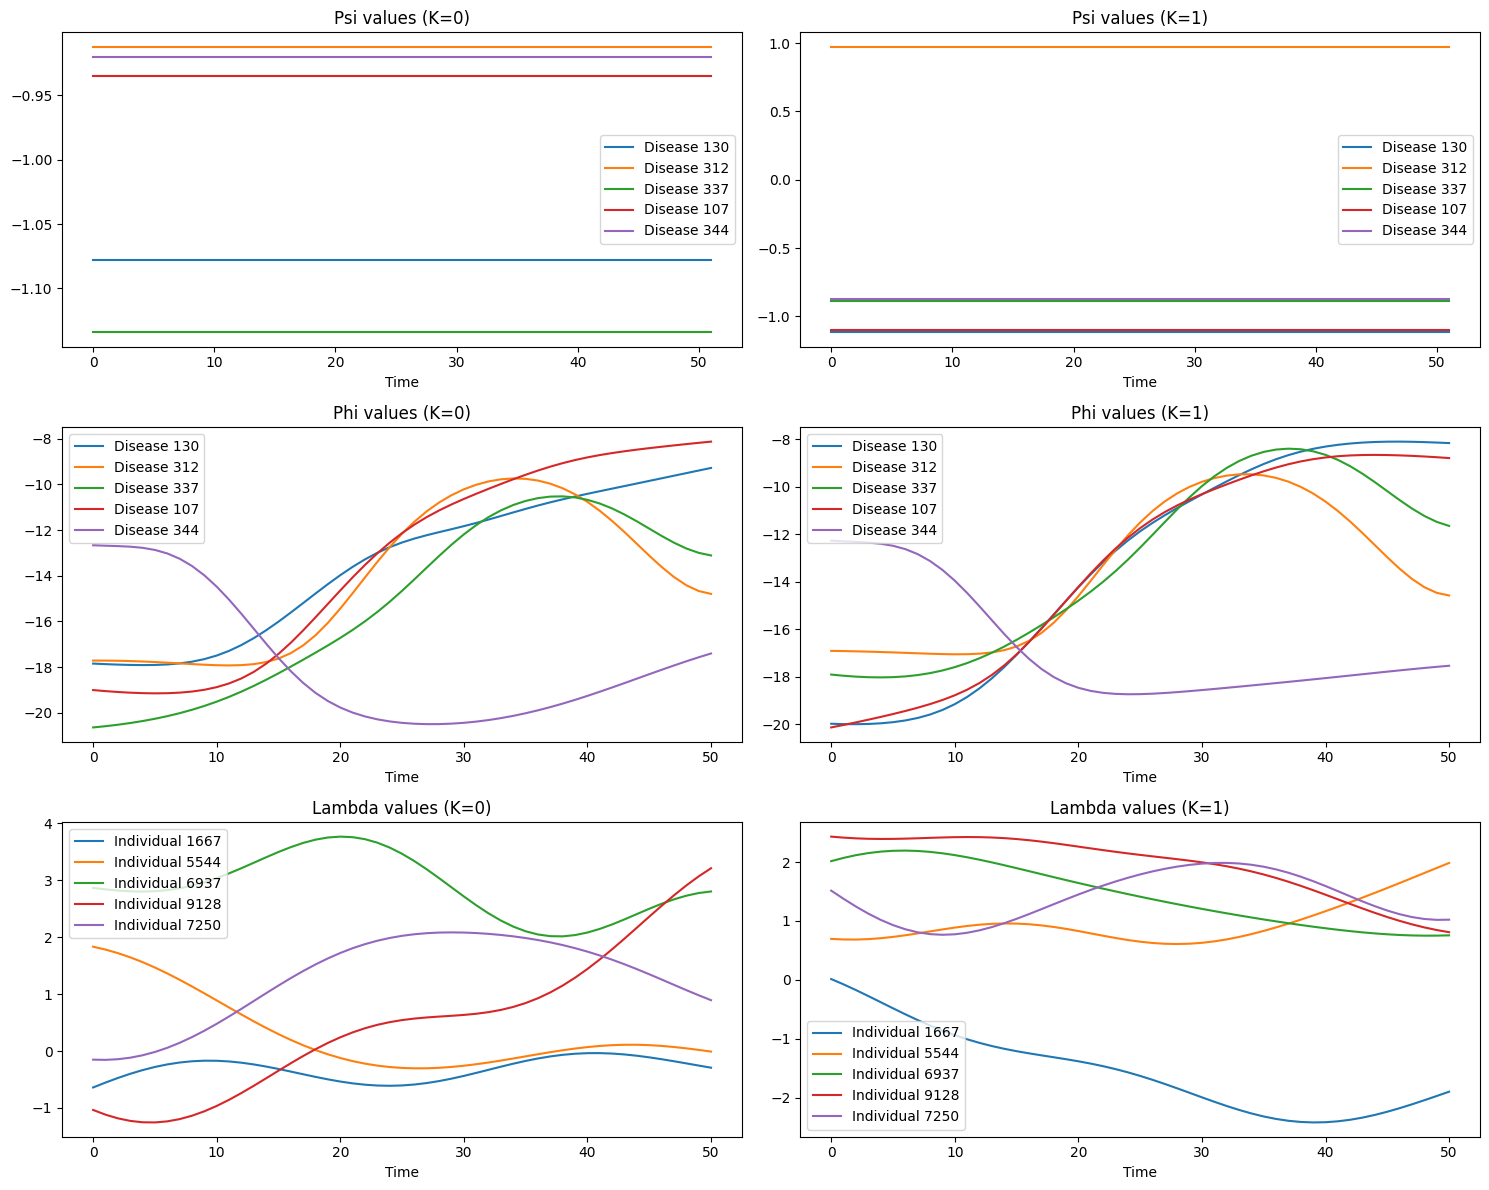


Cluster membership for sampled diseases:
Disease 130: Cluster 16
Disease 312: Cluster 1
Disease 337: Cluster 18
Disease 107: Cluster 4
Disease 344: Cluster 5


TypeError: 'NoneType' object is not subscriptable

In [118]:
 # Get initial rankings from saved initial params
initial_params = model.plot_initial_params()

# Access the initial psi from the returned dictionary
initial_psi = initial_params['psi'].numpy()

In [119]:
def compare_disease_rankings(model, psi_init,disease_names, n_top=10):
    """
    Compare initial vs final disease rankings for each signature
    """
    # Get initial rankings from psi
    psi = psi_init  # Shape: (K, D)
    
    # Get final rankings from centered phi
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Compare rankings for each signature
    for k in range(phi_avg.shape[0]):
        print(f"\nSignature {k}:")
        
        # Get initial top diseases from psi
        initial_scores = psi[k, :]
        initial_top = np.argsort(initial_scores)[-n_top:][::-1]
        
        # Get final top diseases from phi
        final_scores = phi_avg[k, :]
        final_top = np.argsort(final_scores)[-n_top:][::-1]
        
        print("\nInitial top diseases:")
        for i, idx in enumerate(initial_top):
            print(f"{i+1}. {disease_names[idx]}: {initial_scores[idx]:.3f}")
            
        print("\nFinal top diseases:")
        for i, idx in enumerate(final_top):
            print(f"{i+1}. {disease_names[idx]}: {final_scores[idx]:.3f}")
            
        # Calculate rank changes
        initial_ranks = {disease: rank for rank, disease in enumerate(initial_top)}
        final_ranks = {disease: rank for rank, disease in enumerate(final_top)}
        
        # Find diseases that changed ranks significantly
        changed_diseases = set(initial_top) | set(final_top)
        for disease in changed_diseases:
            initial_rank = initial_ranks.get(disease, n_top+1)
            final_rank = final_ranks.get(disease, n_top+1)
            if abs(final_rank - initial_rank) > 2:  # Threshold for significant change
                print(f"\n{disease_names[disease]} changed from rank {initial_rank+1} to {final_rank+1}")

# Run comparison
compare_disease_rankings(model,psi_init, disease_names_list)

NameError: name 'psi_init' is not defined

In [120]:
def visualize_predictions(model, Y, event_times):
    with torch.no_grad():
        pi_pred, _, _ = model.forward()
        pi_pred = pi_pred.cpu().numpy()
    
    N, D, T = Y.shape
    at_risk = np.zeros_like(Y, dtype=bool)
    for n in range(N):
        for d in range(D):
            at_risk[n,d,:event_times[n,d]] = True
    
    # Get predictions
    event_probs = pi_pred[Y == 1 & at_risk]
    nonevent_probs = pi_pred[Y == 0 & at_risk]
    
    plt.figure(figsize=(15, 5))
    
    # 1. Density plot of predictions
    plt.subplot(131)
    plt.hist(event_probs, bins=50, density=True, alpha=0.5, label='Events', color='red')
    plt.hist(nonevent_probs, bins=50, density=True, alpha=0.5, label='Non-events', color='blue')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('Distribution of Predictions')
    plt.legend()
    
    # 2. ROC curve
    from sklearn.metrics import roc_curve, auc
    y_true = np.concatenate([np.ones_like(event_probs), np.zeros_like(nonevent_probs)])
    y_pred = np.concatenate([event_probs, nonevent_probs])
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(132)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    
    # 3. Calibration plot
    from sklearn.calibration import calibration_curve
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)
    
    plt.subplot(133)
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect calibration')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Empirical probability')
    plt.title('Calibration Plot')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Average pi for events: {event_probs.mean():.4f} (std: {event_probs.std():.4f})")
    print(f"Average pi for non-events: {nonevent_probs.mean():.4f} (std: {nonevent_probs.std():.4f})")
    print(f"AUC: {roc_auc:.4f}")
    
    return event_probs, nonevent_probs, roc_auc

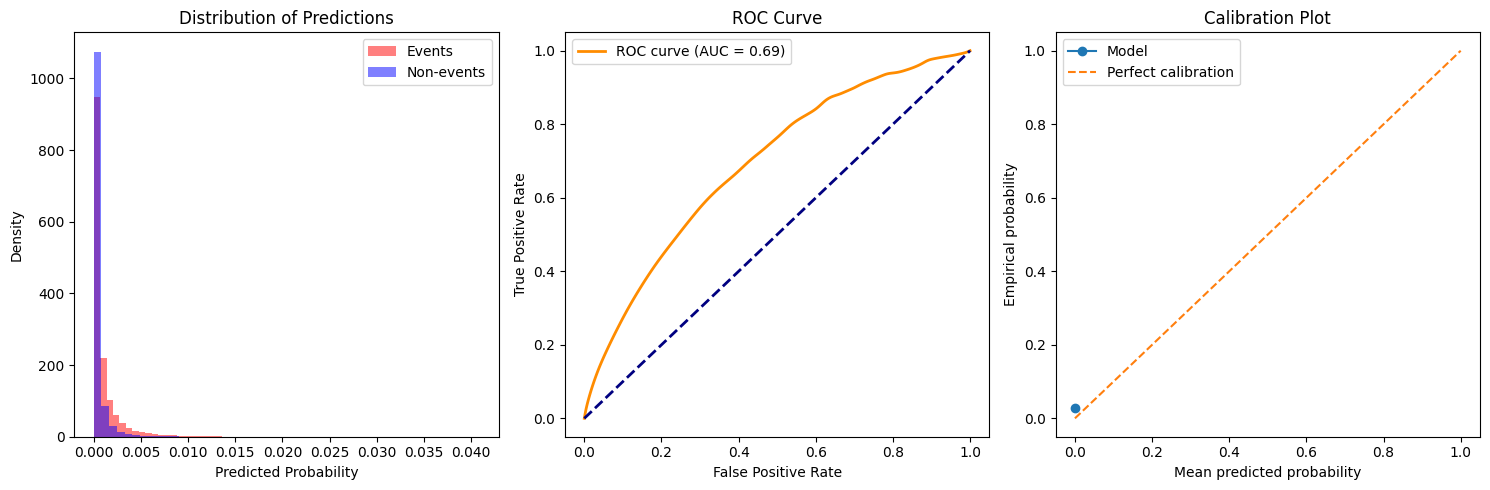

Average pi for events: 0.0010 (std: 0.0017)
Average pi for non-events: 0.0004 (std: 0.0009)
AUC: 0.6917


(array([5.6849360e-05, 5.1999676e-05, 4.6067595e-05, ..., 1.1411139e-06,
        1.8293485e-07, 9.9999999e-09], dtype=float32),
 array([1.e-08, 1.e-08, 1.e-08, ..., 1.e-08, 1.e-08, 1.e-08], dtype=float32),
 0.6917139378216937)

In [35]:
visualize_predictions(model, Y, E)

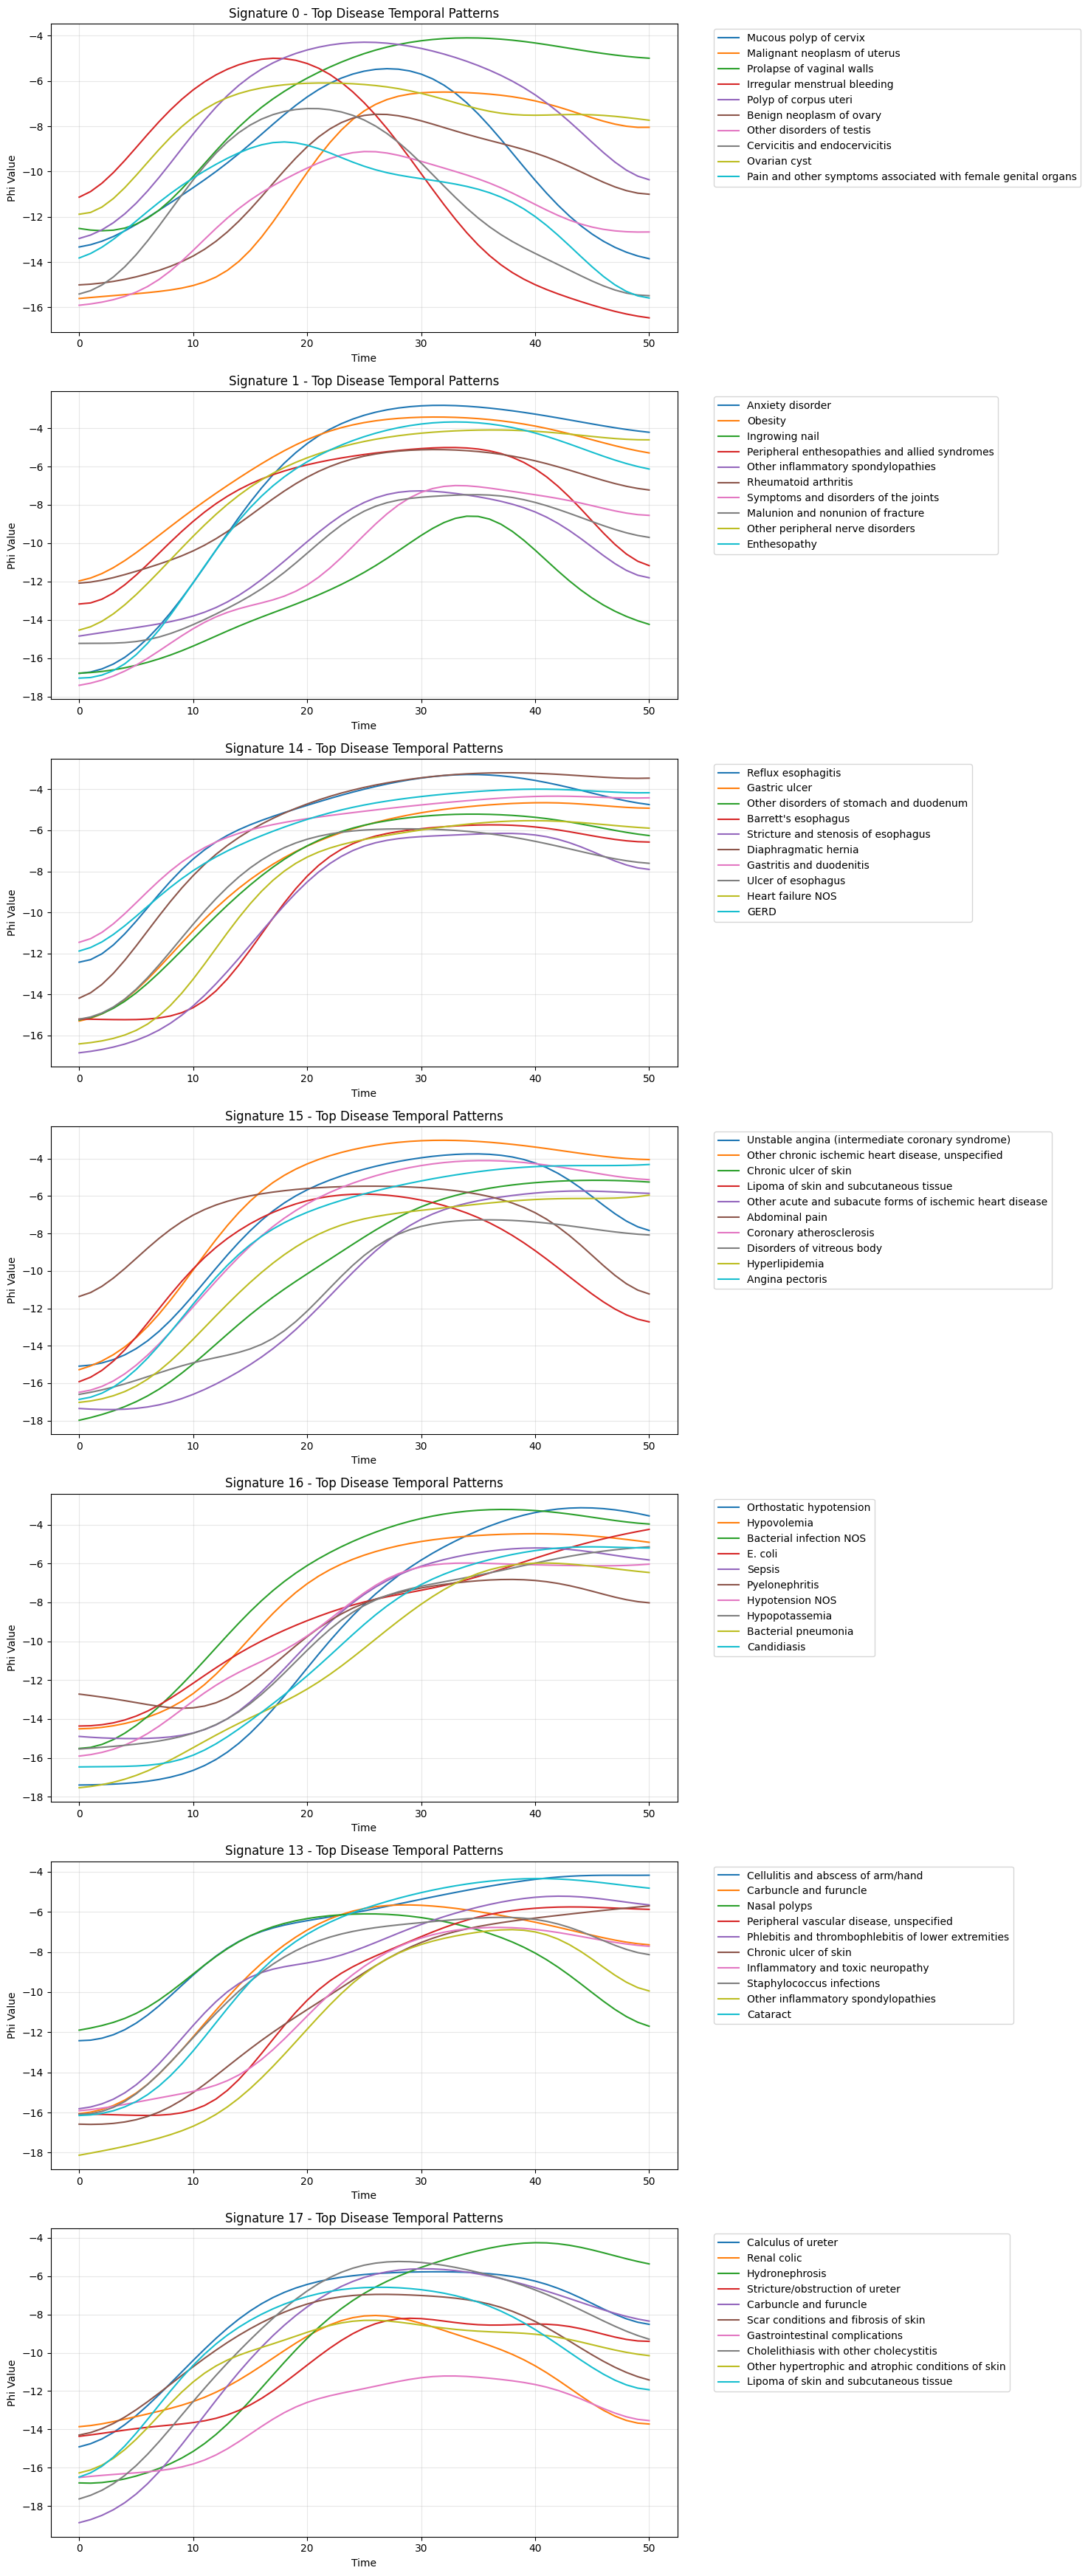

In [121]:
def plot_signature_temporal_patterns(model, disease_names, n_top=10, selected_signatures=None):
    """
    Show temporal patterns of top diseases for each signature
    """
    #phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    #phi_avg = phi.mean(axis=2)  # Average over time

     # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Select which signatures to plot
    if selected_signatures is None:
        selected_signatures = range(phi_avg.shape[0])
    
    # Create subplots for each selected signature
    n_sigs = len(selected_signatures)
    fig, axes = plt.subplots(n_sigs, 1, figsize=(15, 5*n_sigs))
    if n_sigs == 1:
        axes = [axes]
    
    for i, k in enumerate(selected_signatures):
        # Get top diseases
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        # Plot temporal patterns
        ax = axes[i]
        for idx in top_indices:
            temporal_pattern = phi[k, idx, :]
            ax.plot(temporal_pattern, label=disease_names[idx])
        
        ax.set_title(f'Signature {k} - Top Disease Temporal Patterns')
        ax.set_xlabel('Time')
        ax.set_ylabel('Phi Value')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# First show the top diseases


# Then show their temporal patterns
# You can select specific signatures of interest:
plot_signature_temporal_patterns(model, disease_names_list, selected_signatures=[0,1,14,15,16,13,17])

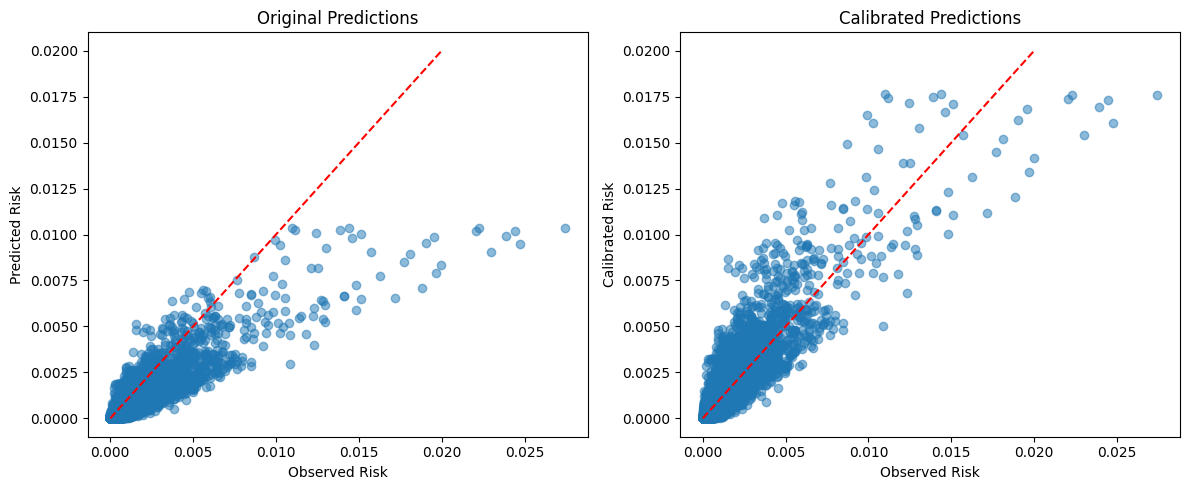

Mean observed risk: 0.000613
Mean predicted risk (original): 0.000360
Mean predicted risk (calibrated): 0.000613
Calibration scale factor: 1.701


In [122]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()

# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [38]:
ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

R^2: 0.778


In [43]:
model.phi

Parameter containing:
tensor([[[-17.3513, -17.4061, -17.4606,  ..., -11.8770, -11.9706, -12.0035],
         [-17.8570, -17.8548, -17.8541,  ..., -15.3026, -15.5415, -15.7175],
         [-15.3491, -15.1891, -14.9265,  ...,  -7.9612,  -7.9552,  -7.9297],
         ...,
         [-17.0145, -17.0028, -16.9526,  ..., -14.2330, -14.4905, -14.6453],
         [-16.7288, -16.7502, -16.7411,  ..., -15.6406, -15.9446, -16.1112],
         [-14.1838, -14.0649, -13.8017,  ..., -18.4899, -18.5608, -18.6253]],

        [[-19.3331, -19.3792, -19.4225,  ..., -13.1002, -13.1767, -13.1946],
         [-17.4179, -17.4133, -17.4130,  ..., -13.3480, -13.4964, -13.5856],
         [-14.5354, -14.3619, -14.0750,  ...,  -4.5808,  -4.6038,  -4.6083],
         ...,
         [-14.9794, -14.9657, -14.9107,  ..., -12.3501, -12.5882, -12.7269],
         [-15.7452, -15.7154, -15.6661,  ..., -17.2671, -17.5708, -17.7396],
         [-13.9800, -13.8147, -13.5286,  ..., -19.1831, -19.1161, -19.0497]],

        [[-18.3582, -1

In [61]:
import numpy as np

K = 20  # number of clusters (0-19)
D = len(model.clusters)
cluster_matrix = np.zeros((K, D))
for d in range(D):
    k = model.clusters[d]
    cluster_matrix[k, d] = 1
# Convert prevalence_logit to a NumPy array if it's a tensor
prevalence_logit_np = model.logit_prev_t.numpy() if isinstance(model.logit_prev_t, torch.Tensor) else model.logit_prev_t


In [60]:
prevalence_logit_np.shape


(348, 51)

In [62]:
prevalence_logit_np_time=prevalence_logit_np.mean(axis=1)

In [63]:
prevalence_logit_np_time.shape

(348,)

In [74]:

# Initialize new psi
psi_new = np.zeros((K, D))
deviation_multiplier = 0.5  # tune this as needed

for k in range(K):
    in_cluster = cluster_matrix[k, :] == 1
    
    if np.any(in_cluster):
        # Get mean prevalence for this cluster
        cluster_mean = prevalence_logit_np_time[in_cluster].mean()
        
        # Set psi based on deviations
        psi_new[k, in_cluster] = deviation_multiplier * (prevalence_logit_np_time[in_cluster] - cluster_mean)
        psi_new[k, ~in_cluster] = -0.5 * deviation_multiplier * (prevalence_logit_np_time[~in_cluster] - cluster_mean)

In [75]:
psi_new

array([[ 0.33252478,  0.63066483, -0.89417195, ..., -0.11080408,
         0.51060748, -1.20670557],
       [ 0.65901923,  0.95715928,  1.135355  , ...,  0.21569037,
         0.83710194,  0.92984724],
       [ 0.73876572,  1.03690577, -0.48793101, ...,  0.29543686,
         0.91684842,  1.00959373],
       ...,
       [ 0.47164726,  0.76978731, -0.75504947, ...,  0.02831841,
         0.64972997,  0.74247527],
       [ 0.87876606, -2.35381222, -0.34793067, ...,  0.4354372 ,
         1.05684876,  1.14959407],
       [-0.97788334,  0.78708172, -0.73775506, ...,  0.04561281,
         0.66702437,  0.75976968]])

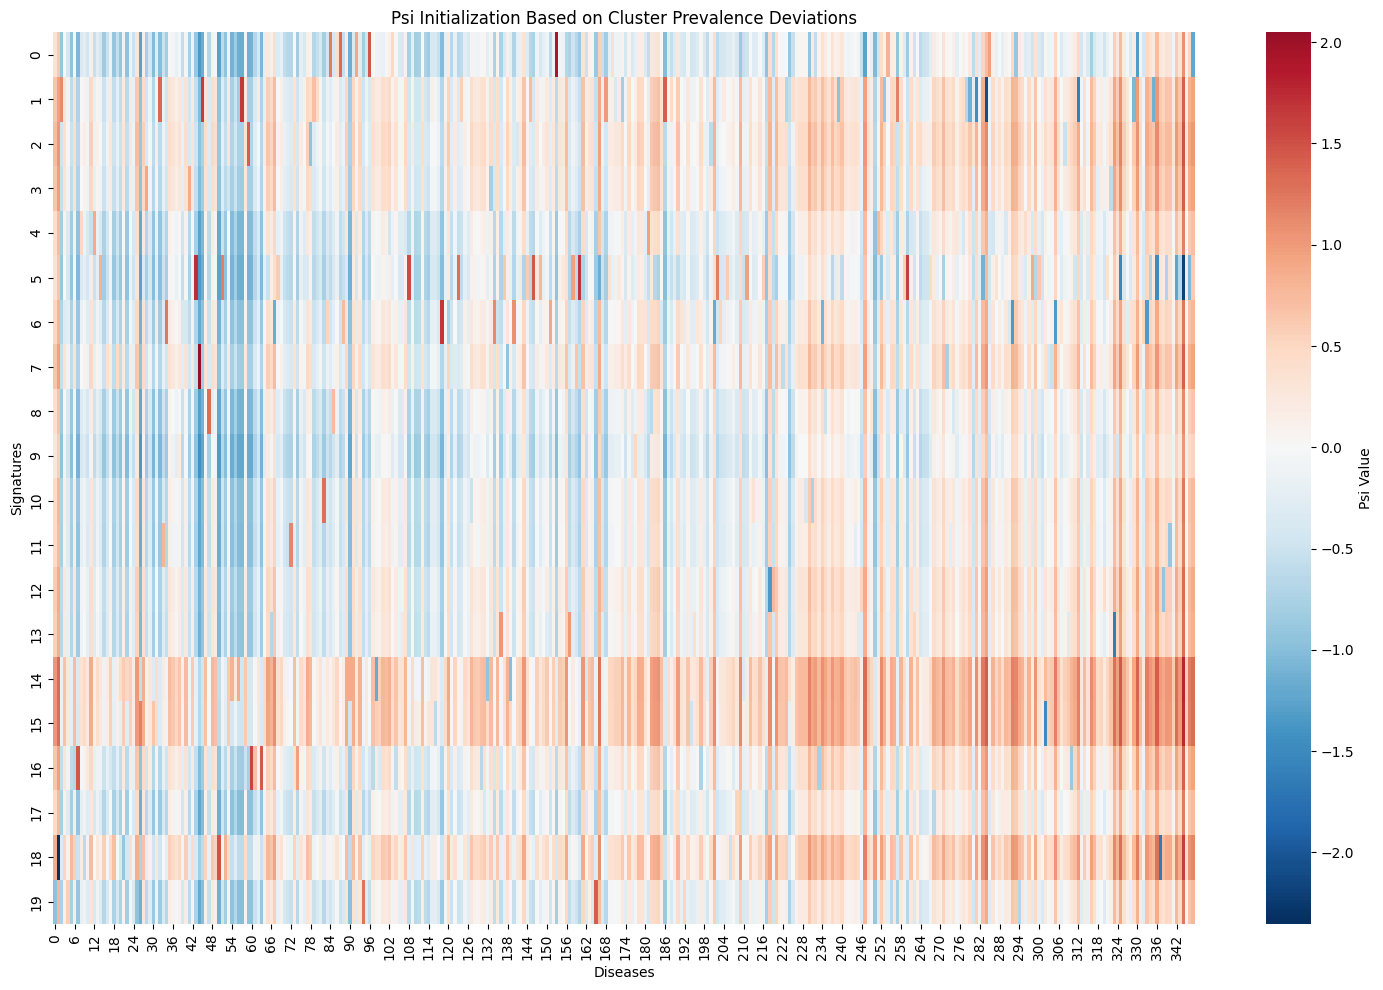

Max psi value: 2.049
Min psi value: -2.354
Mean absolute deviation: 0.406


In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap
# Create heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(psi_new, 
            cmap='RdBu_r', 
            center=0, 
            cbar_kws={'label': 'Psi Value'})

plt.title('Psi Initialization Based on Cluster Prevalence Deviations')
plt.xlabel('Diseases')
plt.ylabel('Signatures')
plt.tight_layout()
plt.show()

# Optional: Print some summary statistics
print(f"Max psi value: {psi_new.max():.3f}")
print(f"Min psi value: {psi_new.min():.3f}")
print(f"Mean absolute deviation: {np.abs(psi_new).mean():.3f}")

In [89]:
prevalence_logit_np_time.shape

(348,)

In [100]:
def top_diseases_before_fitting(model, psi_new, disease_names, n_top=10):
    """
    Display top diseases per signature based on initial phi_centered
    """
    K, D = psi_new.shape
    T = model.logit_prev_t.shape[1]
    
    # Initialize phi_centered (K x D x T)
    phi_centered = np.zeros((K, D, T))
    
    # For each signature k
    for k in range(K):
        # Add logit prevalence (D x T) to psi values (D) for this signature
        # Broadcasting will automatically expand psi_new[k, :] to match T dimension
        phi_centered[k, :, :] = model.logit_prev_t.detach().numpy() + psi_new[k, :].reshape(-1, 1)
        phi_centered[k, :, :] = phi_centered[k, :, :]-model.logit_prev_t.detach().numpy() 

    phi_avg = phi_centered.mean(axis=2) 
            
        # Display top diseases for each signature
    for k in range(K):
        print(f"\nSignature {k}:")
        
        # Get top diseases
        top_indices = np.argsort(phi_avg[k])[-n_top:][::-1]
        
        print("Top diseases:")
        for i, idx in enumerate(top_indices):
            print(f"{i+1}. {disease_names[idx]}: {phi_avg[k, idx]:.3f}")
    


In [101]:
# Example usage
top_diseases_before_fitting(model, psi_new, disease_names_list)


Signature 0:
Top diseases:
1. Uterine leiomyoma: 1.914
2. Prolapse of vaginal walls: 1.451
3. Ovarian cyst: 1.336
4. Polyp of corpus uteri: 1.221
5. Infertility, female: 1.079
6. Endometriosis: 0.957
7. Pelvic peritoneal adhesions, female (postoperative) (postinfection): 0.898
8. Uterine/Uterovaginal prolapse: 0.820
9. Chronic glomerulonephritis, NOS: 0.754
10. Ingrowing nail: 0.717

Signature 1:
Top diseases:
1. Arthropathy NOS: 1.670
2. Major depressive disorder: 1.651
3. Infertility, female: 1.406
4. Internal derangement of knee: 1.406
5. Obesity: 1.361
6. Pain in joint: 1.178
7. Other peripheral nerve disorders: 1.135
8. Chronic glomerulonephritis, NOS: 1.081
9. Hypertrophy of breast (Gynecomastia): 1.039
10. Irregular menstrual cycle: 0.986

Signature 2:
Top diseases:
1. Infertility, female: 1.485
2. Back pain: 1.420
3. Chronic glomerulonephritis, NOS: 1.160
4. Ingrowing nail: 1.123
5. Hypertrophy of breast (Gynecomastia): 1.119
6. Irregular menstrual cycle: 1.065
7. Gastrointest

In [104]:
epsilon=1e-8
Y_avg = torch.mean(Y_tensor, dim=2)  # prevalence is low (near 0)
Y_avg = torch.log((Y_avg + epsilon)/(1-Y_avg+epsilon))  # logit will be negative

In [109]:
Y_avg

tensor([[-17.6983, -17.6983, -17.6983,  ..., -18.4207, -18.4207, -18.4207],
        [-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207],
        [-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207],
        ...,
        [-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207],
        [-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207],
        [-18.4207, -18.4207, -18.4207,  ..., -18.4207, -18.4207, -18.4207]],
       dtype=torch.float64)

In [123]:
Y_logit = torch.log(Y_tensor + epsilon) - torch.log(1 - Y_tensor + epsilon)
Y_avg = torch.mean(Y_logit, dim=2)  #
Y_avg[1000,100]

tensor(-18.4207, dtype=torch.float64)

In [111]:
base_value = Y_avg[:, [5,6,7]].mean(dim=1)  


In [116]:
base_value.shape
base_value.unsqueeze(1).shape

torch.Size([9661, 1])

In [ ]:
# negative value
gamma_init[:, k] = torch.linalg.lstsq(self.G, base_value.unsqueeze(1)).solution.squeeze()